# Exercises and Self Study on Link Prediction with Shallow Embeddings

### Please note, that it matters where you rerun. To be sure, you run all the commands from the start after you have changed some constants

In the following code we will use the idea of simple mapping/transformation from graph to a space of two coordinates given by the layout drawing algorithm. It is simple, not theoretically grounded excercixe just to see how simple embeddings (into a space of two coordinates) affect the link prediction. The idea is simple: the nodes which are connected or supposed to be connected are usually drawn closer to each other and those with many links in common will be drawn even closer, espacially when we have a club bellonging information and we use the spring layout.

In [1]:
import networkx as ntx # networkX library for working with graphs
import numpy as np #numpy with some math and linear algebra
import pandas as pd #data frames for working with tabular data
import scipy # library for scientific computing
import random # library for randomly sampling from data
import math # math functions such as sqrt
import torch # machine learning library - pytorch
import torch_geometric.nn as torchg # libraries with some models for pytorch for example Node2Vec

In [2]:
random.seed(10)

In [3]:
zachary = ntx.karate_club_graph() #importing karate club network

In [4]:
print("Number of nodes: " + str(zachary.number_of_nodes()) + ", Number of edges: " + str(zachary.number_of_edges()) + ".")

Number of nodes: 34, Number of edges: 78.


In [5]:
sampled_edges = random.sample(list(zachary.edges), round(0.2*zachary.number_of_edges()))
print(sampled_edges)

[(30, 32), (0, 5), (20, 33), (23, 33), (32, 33), (0, 2), (2, 8), (23, 29), (24, 25), (4, 6), (1, 17), (31, 33), (28, 31), (8, 30), (0, 11), (0, 31)]


Here we are splitting the nodes into two classes (belonging to a specific club) which affect the coordinates of drawing layouts and hence also embeddings. You can experiment with this. There is also just a homogenious graph set up - the commented line. You may also use multiple classes and multiple attributes but you will need to add that data to the graph, because in current form it only has club belonging as a node attribute.

In [6]:
Y=np.array(list(1.0  if zachary.nodes[n]["club"]=="Officer" else 0.0 for n in zachary.nodes()))
#Y= np.array(list(0.0 for n in zachary.nodes()))

Here you have three different layouts, each likely drawing the graph into a different layout influencing the tranformations, embeddings, and similarities.

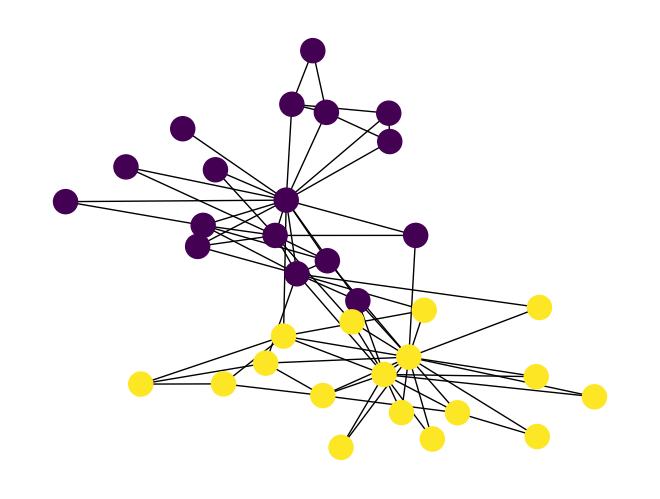

In [7]:
#layout = ntx.circular_layout(zachary)
#layout = ntx.kamada_kawai_layout(zachary)
#layout = ntx.spring_layout(zachary)
# with the seed set for reproducibility
layout = ntx.spring_layout(zachary, seed=0)
ntx.draw(zachary,pos=layout,node_color=Y)

We will make embeddings from the positions in the graph. Please note that the algorithm changes the layout sometimes, so the embeddings and similarities change also. Now the graph is drawn and split on one attribute only. You can play with other attributes to get something else. And please note, that this is not a standard approach. This is just to exemplify some transformation to lowe dimmensional space. It may be it does not work. It will likely work for node classification though. But this is a different task.

In [8]:
X=np.zeros((zachary.order(),2))
for i in range(zachary.order()):
    X[i,:]=layout[i]

In [9]:
print("Embedding vectors: \n",X)

Embedding vectors: 
 [[-0.08608312  0.35674596]
 [-0.10669304  0.20477623]
 [-0.06612635  0.03965846]
 [-0.2406135   0.2481614 ]
 [ 0.10655595  0.60888028]
 [-0.0755657   0.76935902]
 [-0.01136205  0.73449742]
 [-0.25088574  0.15759357]
 [ 0.0472217  -0.07626688]
 [ 0.38513712 -0.10531281]
 [ 0.10468862  0.73088794]
 [-0.27860864  0.66405851]
 [-0.4966925   0.35019105]
 [-0.00950762  0.09581953]
 [ 0.18578961 -0.67118183]
 [ 0.12844744 -0.55763504]
 [-0.036615    1.        ]
 [-0.38425909  0.49969972]
 [ 0.4874534  -0.4897098 ]
 [ 0.15477792  0.20492753]
 [ 0.01593903 -0.70716658]
 [-0.21774876  0.48734977]
 [ 0.37908922 -0.40309779]
 [-0.01793822 -0.48426817]
 [-0.3567273  -0.43493225]
 [-0.20280292 -0.43401062]
 [ 0.38093191 -0.66064669]
 [-0.12433752 -0.34481378]
 [ 0.17073146 -0.11723207]
 [ 0.23263402 -0.55833376]
 [ 0.03637997 -0.16725268]
 [-0.09110846 -0.2283291 ]
 [ 0.09586958 -0.39352437]
 [ 0.14202861 -0.31889215]]


In [10]:
print(zachary.order())
print(len(zachary))

34
34


In [11]:
SimEmbPosition = [[0 for _ in range(zachary.order())] for _ in range(zachary.order())]

In [12]:
for i in range(zachary.order()):
    for j in range(zachary.order()):
        SimEmbPosition[i][j] = np.dot(X[i, :], X[j, :])

In [13]:
#print(SimEmbPosition)

We are going to remove the sampled edges from the graph, so let's just save the similarities if those edges are considered in the graph that we can compare them later. I am going to use a different label for the embeddigns variable XN and also for similarity matrix SimEmbPositionXN.

In [14]:
for u, v in sampled_edges:
    print("(" +  str(u) + ", " + str(v) + ", "  + str(SimEmbPosition[u][v]) + ")")

(30, 32, 0.06930573850345909)
(0, 5, 0.2809706504999708)
(20, 33, 0.22777366664392246)
(23, 33, 0.15188157525151577)
(32, 33, 0.1391080535400731)
(0, 2, 0.01984035673512438)
(2, 8, -0.006147224919384725)
(23, 29, 0.2662102306781111)
(24, 25, 0.26111055554323503)
(4, 6, 0.44601030174569917)
(1, 17, 0.14332439215707893)
(31, 33, 0.05987234824026822)
(28, 31, 0.011212413006036226)
(8, 30, 0.01447376358130889)
(0, 11, 0.26088368826681724)
(0, 31, -0.07361258251098253)


In [15]:
# remove those sampled edges
for uN,vN in sampled_edges:
    zachary.remove_edge(uN, vN)

Of course it will likely affect (maybe only a little bit) the drawing and embeddings, so we need to reconstruct the embeddings. Please observe the changes on the similarity

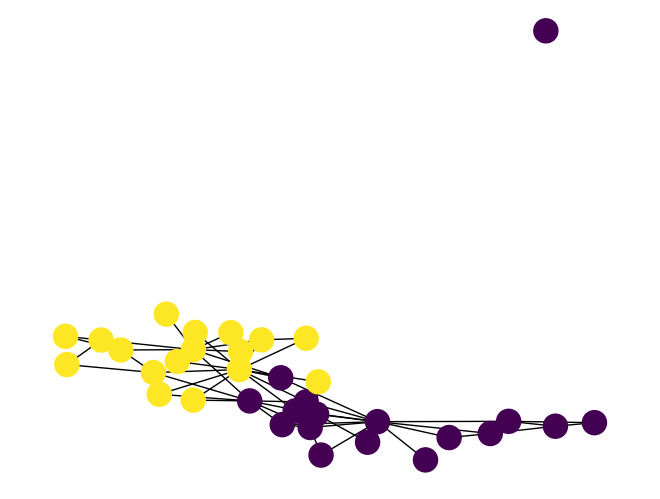

In [16]:
#layoutN = ntx.circular_layout(zachary)
#layoutN = ntx.kamada_kawai_layout(zachary)
#layoutN = ntx.spring_layout(zachary)
# with the seed set for reproducibility
layoutN = ntx.spring_layout(zachary, seed=4)
ntx.draw(zachary,pos=layoutN,node_color=Y)

In [17]:
XN=np.zeros((zachary.order(),2))
for i in range(zachary.order()):
    XN[i,:]=layoutN[i]

In [9]:
print("Embedding vectors: \n",XN)

NameError: name 'XN' is not defined

In [21]:
SimEmbPositionXN = [[0 for _ in range(zachary.order())] for _ in range(zachary.order())]

In [22]:
for i in range(zachary.order()):
    for j in range(zachary.order()):
        SimEmbPositionXN[i][j] = np.dot(XN[i, :], X[j, :])

In [23]:
for u, v in sampled_edges:
    print("(" +  str(u) + ", " + str(v) + ", "  + str(SimEmbPositionXN[u][v]) + ")")

(30, 32, 0.007569581367644506)
(0, 5, -0.1045696365449348)
(20, 33, -0.07643278733171184)
(23, 33, -0.05011404275965524)
(32, 33, -0.039807938888726996)
(0, 2, -0.010973354083533313)
(2, 8, 0.0031656721622642012)
(23, 29, -0.08495259363149985)
(24, 25, 0.030242960333075282)
(4, 6, -0.12884184354993808)
(1, 17, -0.06319579739011866)
(31, 33, -0.06214669668118852)
(28, 31, 0.023899050403239655)
(8, 30, -0.0002500024972445307)
(0, 11, -0.10940127489108349)
(0, 31, 0.020848245024429193)


You can see that the similarities got smaller. Which could also mean that maybe this kind of transformation is not the best one for link predictions.

We can also try to run the test experiment on this in the simlar sense as in the last self study and excercise and accumulate the hit rate or MRR.

In [34]:
k = 10 # the size of the list to consider
countHits = 0 # counter for hits

In [35]:
for u, v in sampled_edges:
    LinkPredictionList = SimEmbPositionXN[u] # extracting list of similar nodes for current node
    sort_index = np.argsort(LinkPredictionList) # sorting according to the similarity value
    position_in_the_list = list(sort_index).index(v) # finding position of the hidden node (the one where the edge was removed and was supposed to be)
    if(position_in_the_list < k-1): countHits = countHits + 1 # adding to the counter if in the position which is within top K

In [36]:
HitRate = countHits / zachary.number_of_nodes()
HitRate = countHits / k

In [37]:
print(HitRate)

0.7


Observe whether the hit rate was better or worse

## Exercises and self studies

1. Please experiment with different layouts and different number of K and rerun the drawing several times. The layout drawing algorithms tend to draw slightly differently each time which will effect coordinates, hence may affect the performance. Experiment with it and reflect on what you see.
2. Load the dataset with paper citations also used last time - the CORA dataset. Similarly to last time, we only need a graph.
4. Rerun the experiment for the cora dataset in the same way and observe and compare the hitrate/mrr. Experiment similarly with differnt drawing and
5. Use SVD and Node2Vec approaches to obtain embeddings and run the same experiment on them. Observe the results and compare with simple embeddings based on coordinates obtained by a layout algorithm.
6. Reflect on your findings and make notes for the exam.

# 1

In [138]:
import networkx as ntx # networkX library for working with graphs
import numpy as np #numpy with some math and linear algebra
import pandas as pd #data frames for working with tabular data
import scipy # library for scientific computing
import random # library for randomly sampling from data
import math # math functions such as sqrt
import torch # machine learning library - pytorch
import torch_geometric.nn as torchg # libraries with some models for pytorch for example Node2Vec

In [139]:
zachary = ntx.karate_club_graph() #importing karate club network
Y=np.array(list(1.0  if zachary.nodes[n]["club"]=="Officer" else 0.0 for n in zachary.nodes()))


random.seed(11)


In [140]:
k = round(0.2*zachary.number_of_edges()) # the size of the list to consider
countHits = 0 # counter for hits

In [141]:
sampled_edges = random.sample(list(zachary.edges), round(0.5*zachary.number_of_edges()))

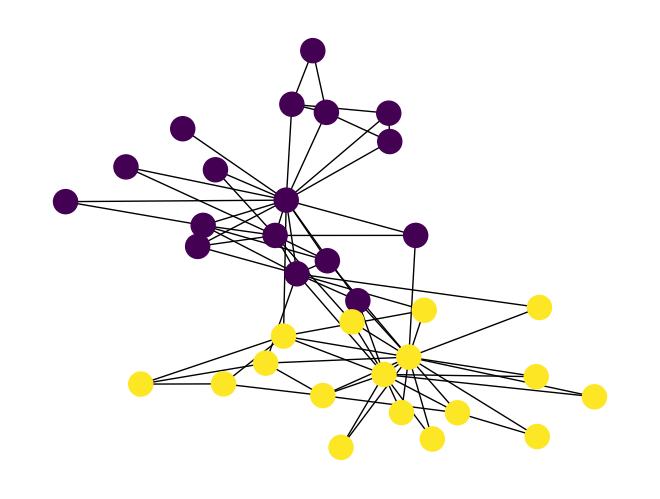

In [142]:
layout = ntx.spring_layout(zachary, seed=0)
X=np.zeros((zachary.order(),2))
for i in range(zachary.order()):
    X[i,:]=layout[i]

ntx.draw(zachary,pos=layout,node_color=Y)

SimEmbPosition = [[0 for _ in range(zachary.order())] for _ in range(zachary.order())]
for i in range(zachary.order()):
    for j in range(zachary.order()):
        SimEmbPosition[i][j] = np.dot(X[i, :], X[j, :])

In [143]:
# remove those sampled edges
for uN,vN in sampled_edges:
    zachary.remove_edge(uN, vN)

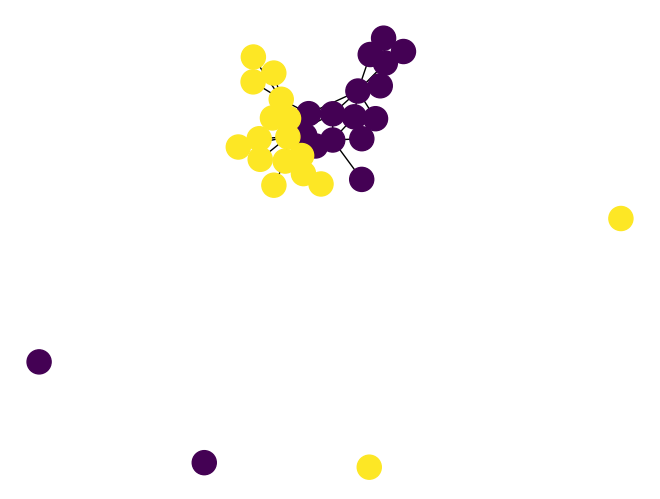

In [144]:
layoutN = ntx.spring_layout(zachary, seed=4)
ntx.draw(zachary,pos=layoutN,node_color=Y)

In [145]:
XN=np.zeros((zachary.order(),2))
for i in range(zachary.order()):
    XN[i,:]=layoutN[i]

In [146]:
SimEmbPositionXN = [[0 for _ in range(zachary.order())] for _ in range(zachary.order())]
for i in range(zachary.order()):
    for j in range(zachary.order()):
        SimEmbPositionXN[i][j] = np.dot(XN[i, :], X[j, :])

In [147]:
for u, v in sampled_edges:
    LinkPredictionList = SimEmbPositionXN[u] # extracting list of similar nodes for current node
    sort_index = np.argsort(LinkPredictionList) # sorting according to the similarity value
    position_in_the_list = list(sort_index).index(v) # finding position of the hidden node (the one where the edge was removed and was supposed to be)
    if(position_in_the_list < k-1): countHits = countHits + 1 # adding to the counter if in the position which is within top K

In [148]:
# HitRate = countHits / zachary.number_of_nodes()
HitRate = countHits / k

print(HitRate)

0.6875


## Answer to 1
I don't think this is the case after all: If all nodes has at least 1 edge, the performance is bad. (Not always the case.)

The performance seems poor overall, taking the xy cordinates as the embedding, does not feel like the right approach.

I don't think it makes sense to count hitrate as number of edges reconstructed / number of nodes. It should be recontructed / removed????



## Answer to 2

2. Load the dataset with paper citations also used last time - the CORA dataset. Similarly to last time, we only need a graph.

In [150]:
coragraph=ntx.readwrite.edgelist.read_edgelist("cora.cites")

In [ ]:
ntx.draw_kamada_kawai(coragraph, with_labels=True) # drawing the network. since this is much larger network, this may take a while

## SVD

SVD methods can be found in many libraries: for example Numpy linear algebra module has one: https://numpy.org/doc/2.2/reference/generated/numpy.linalg.svd.html. There is also an approximate version for sparce datasets.

Pytorch has also a SVD and approximate version of SVD. If we want to have for example 2 dimmensional space coordinates from SVD embeddings, the easiest is to use svd_lowrank from pytorch: https://pytorch.org/docs/stable/generated/torch.svd_lowrank.html.

You can also try to implement the approximate version from the lecture yourself or find another library.

## Node2Vec

Again, there are multiple libraries which you will find out there.
One is for example featured by pytorch in torch geometric - see import up here - https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.Node2Vec.html.

You are welcome to use anoter library or implement it yourself.